## Sandbox for Implementing RetinaNet

- start wih pretrined resnet50, maybe from the original paper, or mybe from fastai, doesn't really matter
- then add feature pyramid network and finetune for coco

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build Feature Pyramid Network (FPN) with ResNet backbone
- Build and train RetinaNet with FPN and object detection subnets

In [1]:
%reload_ext autoreload
%autoreload 200

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.utils.ipython import *

## CamVid

In [3]:
path = untar_data(URLs.CAMVID_TINY)
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [4]:
len(codes)

32

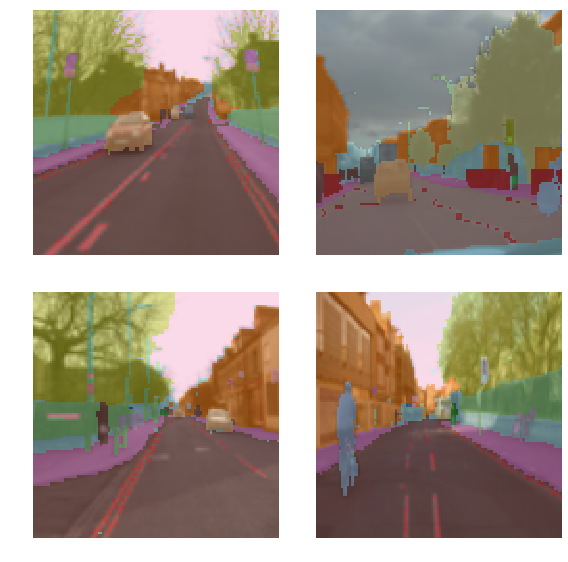

In [5]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
tfms = get_transforms()
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms, tfm_y=True, size=128)
        .databunch(bs=64)
        .normalize(imagenet_stats))
data.show_batch(2)

## U-Net

In [6]:
class Print(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class Flatten(nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)    

In [7]:
class SaveMaps():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = output
    def remove(self): self.hook.remove()

        
@dataclass
class SqueezeTarget(LearnerCallback):
    learn: Learner
    def on_batch_begin(self, **kwargs): 
        return {'last_target': kwargs['last_target'].squeeze(1)}
    
    
def iou(input, targs, classes):
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n, -1)
    targs = targs.contiguous().view(n, -1)
    inp = torch.stack([input==i for i in range(classes)]).cuda()
    tar = torch.stack([targs==i for i in range(classes)]).cuda()
    intersect = lambda a, b: (a*b).sum().float()
    union = lambda a, b: (a+b).sum().float()
    return torch.stack([intersect(a, b)/(union(a, b)-intersect(a, b)+1) for a, b in zip(inp, tar)]).mean()

In [8]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers).cuda()


def conv_block(ic, oc, transpose=False, maxpool=True): 
    layers = [conv(ic, oc, p=1), conv(oc, oc, p=1)]
    if transpose: layers.append(nn.ConvTranspose2d(oc, oc//2, 2, stride=2))
    if maxpool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers).cuda()


def unet_down(cs): 
    layers = [conv_block(cs[i], cs[i+1]) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=True, maxpool=False))
    return nn.Sequential(*layers).cuda()


def unet_up(cs, classes):
    cs.reverse()
    cs.pop()
    layers = [conv_block(cs[i], cs[i+1], transpose=True, maxpool=False) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=False, maxpool=False))
    return nn.ModuleList(layers)


class UNet(nn.Module):
    def __init__(self, channels, classes):
        super().__init__()
        self.unet_down = unet_down(channels)
        self.unet_up = unet_up(channels, classes)
        self.drop_conv = nn.Sequential(conv(channels[-1], classes, k=1, actn=False), nn.Dropout(p=0.))
        self.maps = [SaveMaps(block[-2]) for block in children(self.unet_down)]
        self.maps.pop()
        self.maps.reverse()
        
    def forward(self, x): 
        x = self.unet_down(x)
        for i, m in enumerate(self.unet_up):
            x = torch.cat([self.maps[i].map, x], dim=1)
            x = m(x)
        return self.drop_conv(x)
    
    def close(self): 
        for mp in self.maps: mp.remove()

In [9]:
channels = [3, 64, 128, 256, 512, 1024]
classes = len(data.classes)
model = UNet(channels, classes)

In [10]:
learn = Learner(data, 
                model, 
                metrics=[partial(iou, classes=classes)], 
                opt_func=partial(torch.optim.SGD, momentum=0.99),
                loss_func=F.cross_entropy,
                callback_fns=[SqueezeTarget])
learn.init(nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


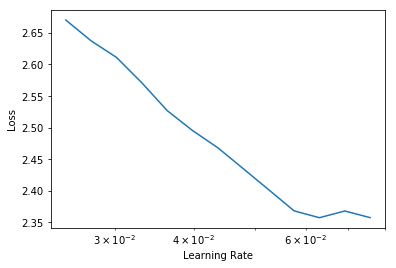

In [11]:
with gpu_mem_restore_ctx():
    learn.lr_find(start_lr=1e-2, end_lr=100)
    learn.recorder.plot()

In [15]:
callbacks = [
    ReduceLROnPlateauCallback(learn, patience=5, factor=0.5), 
    SaveModelCallback(learn, monitor='iou', mode='max', name='unet'), 
    TerminateOnNaNCallback(), GradientClipping(learn, clip=0.1)]
learn.callbacks.extend(callbacks)
learn.fit(200, lr=5e-2)

epoch,train_loss,valid_loss,iou,time
0,1.476287,1.373440,0.057226,00:01
1,1.442360,1.374728,0.057758,00:01
2,1.449409,1.362318,0.058010,00:01
3,1.447614,1.341002,0.057804,00:01
4,1.444863,1.331674,0.056958,00:01
5,1.435101,1.336308,0.056560,00:01
6,1.427298,1.331848,0.056872,00:01
7,1.420670,1.317107,0.057837,00:01
8,1.414675,1.312929,0.059057,00:01
9,1.410087,1.320663,0.059744,00:01


Better model found at epoch 0 with iou value: 0.05722600966691971.
Better model found at epoch 0 with iou value: 0.05722600966691971.
Better model found at epoch 1 with iou value: 0.05775768682360649.
Better model found at epoch 1 with iou value: 0.05775768682360649.
Better model found at epoch 2 with iou value: 0.05801026150584221.
Better model found at epoch 2 with iou value: 0.05801026150584221.
Better model found at epoch 8 with iou value: 0.059056639671325684.
Better model found at epoch 8 with iou value: 0.059056639671325684.
Better model found at epoch 9 with iou value: 0.05974426865577698.
Better model found at epoch 9 with iou value: 0.05974426865577698.
Better model found at epoch 10 with iou value: 0.060009025037288666.
Better model found at epoch 10 with iou value: 0.060009025037288666.
Better model found at epoch 11 with iou value: 0.06002717465162277.
Better model found at epoch 11 with iou value: 0.06002717465162277.


Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/h

KeyboardInterrupt: 

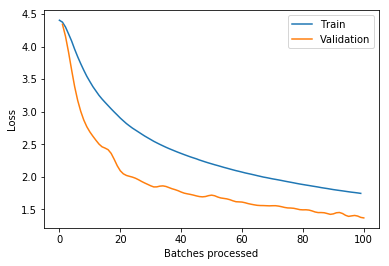

In [13]:
learn.recorder.plot_losses()

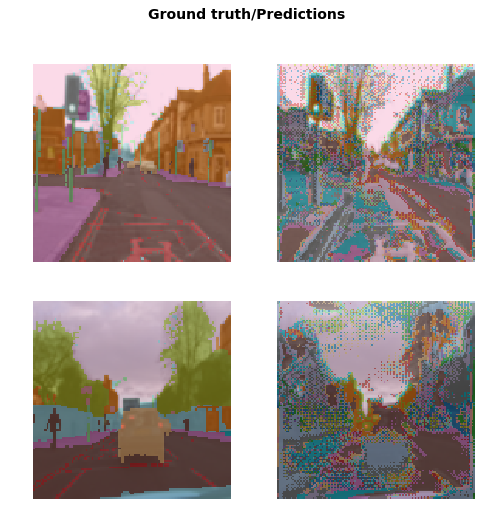

In [14]:
learn.show_results(rows=2)

In [ ]:
learn.fit()